In [45]:
# Author: Banafsheh Khazali, Claudeth Cl
# Date: August 2022
# The main idea belongs to https://www.frontiersin.org/articles/10.3389/fncom.2019.00008/full

In [46]:
import time 
import os 
import numpy as np
import scipy.io as sio
from scipy import integrate, signal, sparse, linalg 
import matplotlib.pyplot as plt 
import pandas as pd

In [47]:
# Reading neuron names
neuron_names =  pd.read_csv('neuron_names.txt', names=["Neuron","NAN"])

df = pd.DataFrame(neuron_names)
df.drop("NAN", axis=1, inplace=True)
df["Neuron"]=df["Neuron"].str.replace("u","")
df["Neuron"]=df["Neuron"].str.replace("'","")
df["Neuron"]=df["Neuron"].str.replace(" ","")
df

,Neuron
0,IL2DL
1,IL2VL
2,IL2L
3,URADL
4,IL1VL
...,...
274,PHCL
275,PVNR
276,PLMR
277,PVNL


In [48]:
NeuronArray=df["Neuron"].values
NeuronArray

array(['IL2DL', 'IL2VL', 'IL2L', 'URADL', 'IL1VL', 'IL2DR', 'IL1DL',
       'OLLL', 'IL1L', 'URYDL', 'OLQDL', 'URYDR', 'IL2R', 'URYVL', 'RIPL',
       'OLLR', 'URBL', 'IL2VR', 'IL1DR', 'URADR', 'IL1R', 'URAVL',
       'OLQVL', 'RMED', 'URBR', 'OLQDR', 'URYVR', 'RIPR', 'RMEL', 'BAGL',
       'CEPVL', 'BAGR', 'OLQVR', 'URAVR', 'RMER', 'IL1VR', 'RID', 'CEPVR',
       'RMEV', 'CEPDL', 'RMDVL', 'SAAVL', 'SMDVL', 'URXL', 'ALA', 'RMDVR',
       'CEPDR', 'AVAL', 'RIAL', 'ASKL', 'SAAVR', 'RMDL', 'URXR', 'SMDVR',
       'AFDL', 'AVAR', 'RIAR', 'ASKR', 'AVEL', 'ADLL', 'ADFL', 'RMDR',
       'AFDR', 'SIBDL', 'RIH', 'AWBL', 'AVER', 'RMDDL', 'AWCL', 'ADFR',
       'ASGL', 'SAADL', 'ADLR', 'AWAL', 'AWBR', 'ASIL', 'ASHL', 'SIBDR',
       'ASGR', 'AIBL', 'ASHR', 'AWCR', 'AWAR', 'SIBVL', 'RIVL', 'SMDDL',
       'SAADR', 'RMHL', 'RMDDR', 'ASIR', 'AVHL', 'AVHR', 'RIVR', 'AIBR',
       'RIBL', 'RMFL', 'AVBL', 'SIBVR', 'ASEL', 'AVJR', 'AUAL', 'SIADL',
       'RMHR', 'AVJL', 'ASER', 'AVBR', 'RIBR', 'RMFR', '

In [49]:
NeuronArray.shape # Network has 279 neurons

(279,)

In [50]:
# we want to stimulate a specific neuron which here is PLML and PLMR neurons
# and the reason is that we want to simulate forward crawling motion
InpVec=np.zeros(279)

InpVec[276] = 1.4
InpVec[278] = 1.4
      
InpVec

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

In [51]:
# Initial Conditions for simulation

# Number of neurons
N = 279
# Cell membrane conductance (pS)
Gc = 0.1
# Cell Membrane Capacitance
C = 0.015
# Leakage potential (mV)
Ec = -35.0

# Synaptic Activity Parameters
ar = 1.0/1.5 # Synaptic activity's rise time
ad = 5.0/1.5 # Synaptic activity's decay time
B = 0.125 # Width of the sigmoid (mv^-1)

In [52]:
# Gap Junctions (Electrical, 279*279)
ggap = 1.0 
# Synaptic connections (Chemical, 279*279)
gsyn = 1.0 

In [53]:
# Gap Junctions (Electrical, 279*279)
Gg_Static = np.load('Gg.npy') 
print(Gg_Static)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [54]:
# Synaptic connections (Chemical, 279*279)
Gs_Static = np.load('Gs.npy') #No sé qué es Gs
print(Gs_Static)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [55]:
# Directionality (279*1)
E = np.load('emask.npy') 
E = -48.0 * E 
EMat = np.tile(np.reshape(E, N), (N, 1))

In [56]:
Gcmat = np.multiply(Gc, np.eye(N))
M1 = -Gcmat
M1

array([[-0.1, -0. , -0. , ..., -0. , -0. , -0. ],
       [-0. , -0.1, -0. , ..., -0. , -0. , -0. ],
       [-0. , -0. , -0.1, ..., -0. , -0. , -0. ],
       ...,
       [-0. , -0. , -0. , ..., -0.1, -0. , -0. ],
       [-0. , -0. , -0. , ..., -0. , -0.1, -0. ],
       [-0. , -0. , -0. , ..., -0. , -0. , -0.1]])

In [57]:
EcVec = np.multiply(Ec, np.ones((N, 1)))

In [58]:
b1 = np.multiply(Gc, EcVec)

In [59]:
s_eq = round((ar/(ar + 2 * ad)), 4)
S_eq = np.multiply(s_eq, np.ones((N, 1)))
S_eq

array([[0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909],
       [0.0909

In [60]:
sjmat = np.multiply(s_eq, np.ones((N, N)))
sjmat

array([[0.0909, 0.0909, 0.0909, ..., 0.0909, 0.0909, 0.0909],
       [0.0909, 0.0909, 0.0909, ..., 0.0909, 0.0909, 0.0909],
       [0.0909, 0.0909, 0.0909, ..., 0.0909, 0.0909, 0.0909],
       ...,
       [0.0909, 0.0909, 0.0909, ..., 0.0909, 0.0909, 0.0909],
       [0.0909, 0.0909, 0.0909, ..., 0.0909, 0.0909, 0.0909],
       [0.0909, 0.0909, 0.0909, ..., 0.0909, 0.0909, 0.0909]])

In [61]:
Gg_Dynamic = Gg_Static.copy() 
Gs_Dynamic = Gs_Static.copy() 

In [62]:
# Input_Mask/Continuous Transtion
transit_Mat = np.zeros((2, N)) 
zero = np.zeros(N)
t_Tracker = 0 
Iext = 100000  # external input

rate = 0.025 
offset = 0.15

transit_Mat

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [63]:
# Data matrix stack size
stack_Size = 5 
init_data_Mat = np.zeros((stack_Size + 50, N)) 
data_Mat = np.zeros((stack_Size, N)) 

In [64]:
# Mask transition
def transit_Mask(input_Array):

    
    global t_Switch, oldMask, newMask, transit_End, Vth_Static

   
    transit_Mat[0,:] = transit_Mat[1,:]
    t_Switch = t_Tracker
    transit_Mat[1,:] = input_Array
    oldMask = transit_Mat[0,:]
    newMask = transit_Mat[1,:]
    transit_End = t_Switch + 0.3
    print("el oldMask es",oldMask,"\n")
    print("el newMask es",newMask,"\n")
    print("el t_Switch es: ",t_Switch,"\n")
    print("el transit_End es: ",transit_End)
    

In [65]:
transit_Mask(InpVec)

el oldMask es [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

el newMask es [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

$S_{transit} = S_{old} (\frac{1}{2}-\frac{1}{2}(\tanh[\frac{t-(t_{switch}+t_{offset})}{r}])) + S_{new} (\frac{1}{2}+\frac{1}{2}(\tanh[\frac{t-(t_{switch}+t_{offset})}{r}])) $ 

In [66]:
# Stimulation Process
def update_Mask(old, new, t, tSwitch):

    return np.multiply(old, 0.5-0.5*np.tanh((t-tSwitch)/rate)) + np.multiply(new, 0.5+0.5*np.tanh((t-tSwitch)/rate))


In [67]:
# Ablation
def modify_Connectome(ablation_Array):

    global Vth_Static, Gg_Dynamic, Gs_Dynamic

    apply_Col = np.tile(ablation_Array, (N, 1))
    apply_Row = np.transpose(apply_Col)
    apply_Mat = np.multiply(apply_Col, apply_Row)
    Gg_Dynamic = np.multiply(Gg_Static, apply_Mat)
    Gs_Dynamic = np.multiply(Gs_Static, apply_Mat)

    try:
        newMask
   
    except NameError:

    
        EffVth(Gg_Dynamic, Gs_Dynamic)

        if np.sum(ablation_Array) != N:
            print("Neurons " + str(np.where(ablation_Array == False)[0]) + " are ablated")
        
        
        else:
            print("All Neurons healthy")
        print("EffVth Recalculated")

    
    else:

        EffVth(Gg_Dynamic, Gs_Dynamic)
        Vth_Static = EffVth_rhs(Iext, newMask)
        if np.sum(ablation_Array) != N:
            print("Neurons " + str(np.where(ablation_Array == False)[0]) + " are ablated") 
        

        else:

            print("All Neurons healthy")

        
        print("EffVth Recalculated")
        print("Vth Recalculated") 

In [68]:
# Efficient V-threshold computation

def EffVth(Gg, Gs, InMask, Iext):
    
    Ggap = np.multiply(ggap, Gg)
    Ggapdiag = np.subtract(Ggap, np.diag(np.diag(Ggap)))
    Ggapsum = Ggapdiag.sum(axis = 1)
    Ggapsummat = sparse.spdiags(Ggapsum, 0, N, N).toarray()
    M2 = -np.subtract(Ggapsummat, Ggapdiag)
    Gs_ij = np.multiply(gsyn, Gs)
    Gsyn = np.multiply(sjmat, Gs_ij)
    Gsyndiag = np.subtract(Gsyn, np.diag(np.diag(Gsyn)))
    Gsynsum = Gsyndiag.sum(axis = 1)
    M3 = -sparse.spdiags(Gsynsum, 0, N, N).toarray()
    b3 = np.dot(Gs_ij, np.multiply(s_eq, E))

    A = M1 + M2 + M3
    
    global LL, UU, bb
    (P, LL, UU) = linalg.lu(A)
    bbb = -b1 - b3
    bb = np.reshape(bbb, N)
    InputMask = np.multiply(Iext, InMask)
    b = np.subtract(bb, InputMask)

    Vth = linalg.solve_triangular(UU, linalg.solve_triangular(LL, b, lower = True, check_finite=False), check_finite=False)

    return Vth


In [69]:
v1 = EffVth(Gg_Dynamic, Gs_Dynamic,InpVec, Iext)
v1

array([-3.50000000e+01, -1.83342064e+01,  1.12458180e+01, -4.75349722e+00,
        9.01994520e-01, -3.50000000e+01,  8.72625067e+00,  2.78413212e+01,
        2.48751631e+00,  3.53239176e+02,  4.05828324e+01,  2.65131317e+02,
        4.59940678e+00,  2.81007486e+02,  1.21332292e-01,  2.10424699e+01,
        2.70038441e+01, -9.39093104e+00,  7.34114719e+00, -6.31199279e+00,
        1.66837183e+00, -6.31199279e+00,  3.92624357e+01,  4.16286258e+00,
        2.23130794e+01,  4.10740707e+01,  3.88861256e+02,  1.01138629e-01,
        2.60304401e+01,  3.28845396e+01,  2.85445292e+01,  3.26347000e+01,
        2.90939420e+01, -6.31199279e+00,  2.88903557e+00,  8.75673650e-01,
        5.11673012e+02,  2.50987824e+01,  1.35058858e+01,  3.18834447e+01,
        1.46548129e+01,  2.14180786e+01,  6.29981828e+01,  7.66166631e+00,
        3.70199615e+02,  1.55206509e+01,  3.47876761e+01,  8.16234264e+02,
       -3.40440433e-01,  2.38115653e+01,  3.30104019e+00,  1.88797141e+00,
        4.39924813e+00,  

In [70]:
def voltage_filter(v_vec, vmax, scaler):
    
    filtered = vmax * np.tanh(scaler * np.divide(v_vec, vmax))
    
    return filtered


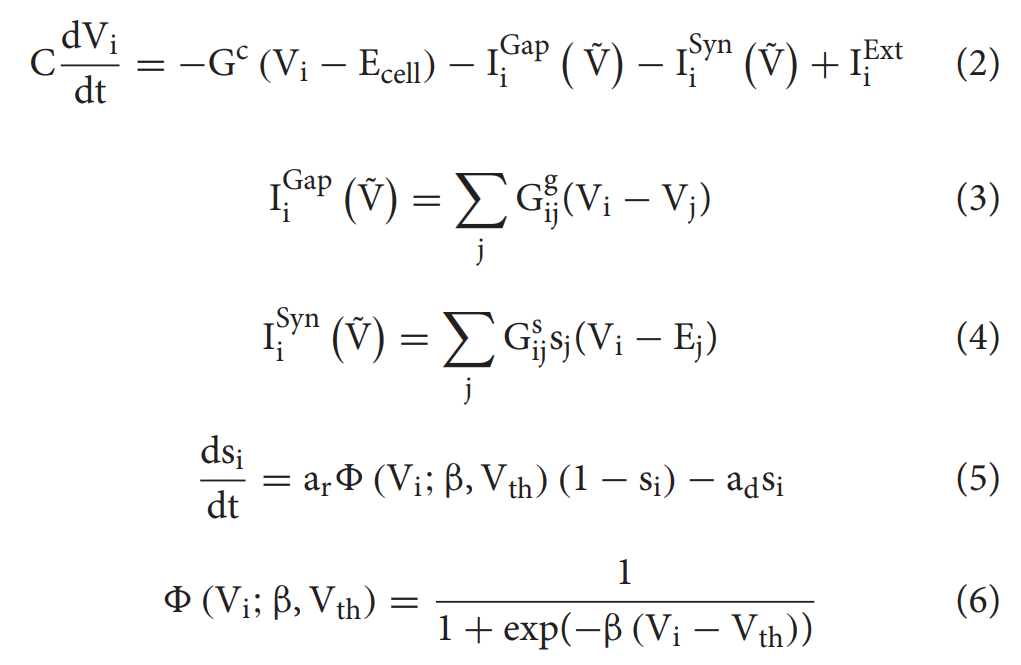

In [71]:
# Right hand side of the equation
def membrane_voltageRHS(t, y):

    # Split the incoming values
    Vvec, SVec = np.split(y, 2)
    # Gc(Vi - Ec)
    VsubEc = np.multiply(Gc, (Vvec - Ec))
    # Gg(Vi - Vj) Computation
    Vrep = np.tile(Vvec, (N, 1))
    GapCon = np.multiply(Gg_Dynamic, np.subtract(np.transpose(Vrep), Vrep)).sum(axis = 1)
    # Gs*S*(Vi - Ej) Computation
    VsubEj = np.subtract(np.transpose(Vrep), EMat)
    SynapCon = np.multiply(np.multiply(Gs_Dynamic, np.tile(SVec, (N, 1))), VsubEj).sum(axis = 1)

    global InMask, Vth

    if t >= t_Switch and t <= transit_End:

        InMask = update_Mask(oldMask, newMask, t, t_Switch + offset)
        Vth = EffVth(Gg_Dynamic, Gs_Dynamic, InMask, Iext)

    else:

        InMask = newMask
        Vth = Vth_Static
        
    Input = np.multiply(Iext, InMask)
    # ar*(1-Si)*Sigmoid Computation
    SynRise = np.multiply(np.multiply(ar, (np.subtract(1.0, SVec))),
                          np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth)))))
    SynDrop = np.multiply(ad, SVec)
    dV = (-(VsubEc + GapCon + SynapCon) + Input)/C
    dS = np.subtract(SynRise, SynDrop)
  
    return np.concatenate((dV, dS))

In [72]:
def compute_jacobian(t, y):

    # Split the incoming values
    Vvec, SVec = np.split(y, 2)
    Vrep = np.tile(Vvec, (N, 1))

    
    J1_M1 = -np.multiply(Gc, np.eye(N))
    
    Ggap = np.multiply(ggap, Gg_Dynamic)
    
    Ggapsumdiag = -np.diag(Ggap.sum(axis = 1))
    
    J1_M2 = np.add(Ggap, Ggapsumdiag) 
    
    Gsyn = np.multiply(gsyn, Gs_Dynamic)
    
    J1_M3 = np.diag(np.dot(-Gsyn, SVec))

    J1 = (J1_M1 + J1_M2 + J1_M3) / C

    J2_M4_2 = np.subtract(EMat, np.transpose(Vrep))
    J2 = np.multiply(Gsyn, J2_M4_2) / C

    global InMask, Vth

    if t >= t_Switch and t <= transit_End:

        InMask = update_Mask(oldMask, newMask, t, t_Switch + offset)
        Vth = EffVth(Gg_Dynamic, Gs_Dynamic, InMask, Iext)

    else:

        InMask = newMask
        Vth = Vth_Static

    sigmoid_V = np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth))))
    J3_1 = np.multiply(ar, 1 - SVec)
    J3_2 = np.multiply(B, sigmoid_V)
    J3_3 = 1 - sigmoid_V
    J3 = np.diag(np.multiply(np.multiply(J3_1, J3_2), J3_3))

    J4 = np.diag(np.subtract(np.multiply(-ar, sigmoid_V), ad))

    J_row1 = np.hstack((J1, J2))
    J_row2 = np.hstack((J3, J4))
    J = np.vstack((J_row1, J_row2))

    return J

In [73]:
# Simulation initiator
def run_Network(t_Delta, atol):

    dt = t_Delta
    
    vi=[]

    InitCond = 10**(-4)*np.random.normal(0, 0.94, 2*N)

# Configuring the ODE Solver """
    r = integrate.ode(membrane_voltageRHS, compute_jacobian).set_integrator('vode', atol = atol, min_step = dt*1e-6, method = 'bdf')
    r.set_initial_value(InitCond, 0)

    init_data_Mat[0, :] = InitCond[:N]

    global oldMask, t_Switch, t_Tracker, transit_End


    try:
        newMask

    except NameError:

        transit_Mask(np.zeros(N))

    else:

        oldMask = newMask.copy()

    t_Switch = 0
    transit_End = 0.3
    k = 1

    while r.successful() and k < stack_Size + 50:

        r.integrate(r.t + dt)
        data = np.subtract(r.y[:N], Vth)
        init_data_Mat[k, :] = voltage_filter(data, 500, 1)
        t_Tracker = r.t
        k += 1

        vi.append(data)
    return vi
    

In [74]:
# run the simulator with the initialization parameters mentioned in this paper
# https://www.frontiersin.org/articles/10.3389/fncom.2019.00008/full
run_Network(0.1, 10**(-9))

/var/folders/1l/qw83q2k515n_b2b4pjrqlpbr0000gq/T/ipykernel_7981/2413802808.py:30: RuntimeWarning: overflow encountered in exp
  np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth)))))
/var/folders/1l/qw83q2k515n_b2b4pjrqlpbr0000gq/T/ipykernel_7981/1256732713.py:37: RuntimeWarning: overflow encountered in exp
  sigmoid_V = np.reciprocal(1.0 + np.exp(-B*(np.subtract(Vvec, Vth))))
/Users/banafshehkhazali/anaconda3/envs/research/lib/python3.8/site-packages/scipy/integrate/_ode.py:1011: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


[array([ 3.11064271e+01,  1.44420178e+01, -8.03829175e+00,  9.22319685e-01,
        -8.81182675e-01,  3.11063511e+01,  7.15350228e+00,  1.31562494e+01,
        -2.32853669e+00,  1.23847472e+02,  4.97016614e+01,  8.47233363e+01,
        -6.70762057e+00,  7.98268304e+01,  5.16030072e-01,  1.38670437e+01,
         4.56724002e+00,  5.50633965e+00,  7.67978438e+00,  2.47861984e+00,
        -2.10134435e+00,  2.46529583e+00,  4.26482326e+01,  1.23019027e+01,
        -1.87890029e+00,  3.56966362e+01,  7.79045112e+01,  5.60916488e-01,
         2.76717645e+01,  2.55135684e-01, -1.10329508e+00,  8.09845330e+00,
         2.84299853e+01,  2.47048044e+00,  1.07079768e+01, -3.50981167e+00,
         2.97450773e+02, -2.68047886e+00,  5.49093299e+01, -2.55946846e+00,
         6.00778018e+01,  1.38102530e+01,  1.08107439e+02, -4.45533754e+00,
        -1.33604157e+02,  7.59947861e+01,  7.88575636e-01,  7.60100966e+02,
        -3.17843721e+00,  7.34457624e+00,  1.06660042e+01,  1.86628609e+01,
        -6.4